In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [2]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

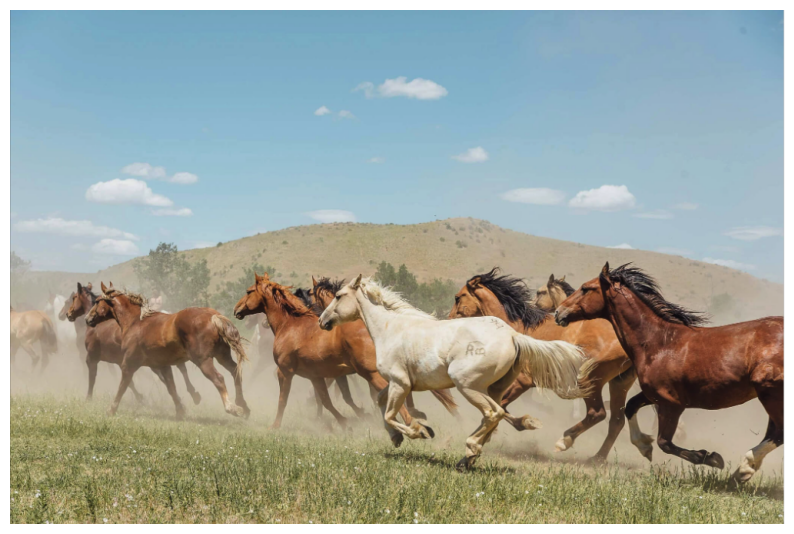

In [3]:
image = cv2.imread('horses.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [4]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device=torch.device('mps' if torch.cuda.is_available() else 'cpu')
print(device)

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

cpu


In [5]:
masks = mask_generator.generate(image)

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


In [6]:
print(masks[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


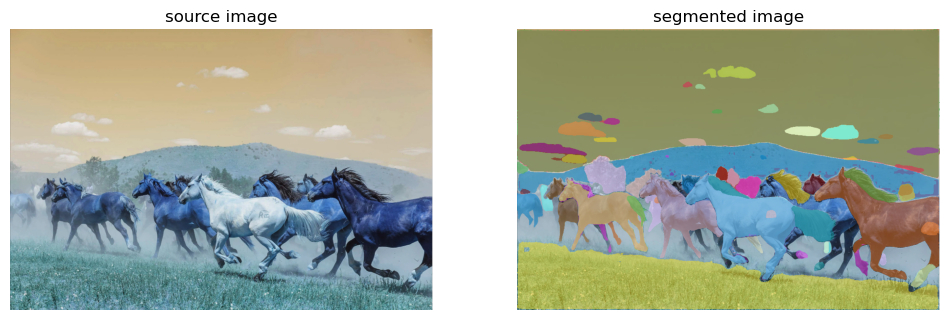

In [7]:
import supervision as sv

mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=masks)

annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

sv.plot_images_grid(
    images=[image, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [47]:
import os
import glob

### sort masks according to area descendingly
masks = sorted(masks, key=lambda x: x['area'], reverse=True)

segmented_masks = [
    mask['segmentation']
    for mask in masks
]

styled_images = []
org_image = cv2.imread('horses.png')

linear_style_transfer_file = '/Users/ayberk.cansever/Documents/ECU/Thesis/LinearStyleTransfer/linearstyletransfer.py'

for i in range(4,5):
    mask = (segmented_masks[i] * 255).astype(np.uint8) 
    masked_image = cv2.bitwise_and(org_image, org_image, mask=mask)
    
    masked_image_file = './output/masked-' + str(i) + '.png'
    cv2.imwrite(masked_image_file, masked_image)
    
    bbox = masks[i]['bbox']
    x_min = bbox[0]
    x_max = bbox[0] + bbox[2]
    y_min = bbox[1]
    y_max = bbox[1] + bbox[3]
    bbox_mask = mask[y_min:y_max, x_min:x_max]
        
    bbox_masked_image = masked_image[y_min:y_max, x_min:x_max]
    bbox_image = './output/bbox-masked-' + str(i) + '.png'
    cv2.imwrite(bbox_image, bbox_masked_image)
    
    bbox_masked_image_file = './output/bbox-masked-' + str(i) + '.png'
    org_styled_image_file = './output/org-style-' + str(i) + '.jpg'
    masked_style_image_file = './styles/style-' + str(i) + '.jpg'
    styled_image_file = './output/styled-' + str(i) + '.png'
    bbox_styled_image_file = './output/bbox-styled-' + str(i) + '.png'
    
    print('Styling image-' + str(i) + '...')
    #os.system('python ' + linear_style_transfer_file + ' ' + masked_image_file + ' ' + masked_style_image_file + ' ' + styled_image_file)
    
    ### styling and then masking - START
    os.system('python ' + linear_style_transfer_file + ' ' + 'horses.png' + ' ' + style_image_file + ' ' + org_styled_image_file)
    org_styled_image = cv2.imread(org_styled_image_file)
    target_height, target_width = org_image.shape[:2]
    org_styled_image = cv2.resize(org_styled_image, (target_width, target_height), interpolation=cv2.INTER_LINEAR)
    
    inverse_mask = cv2.bitwise_not(mask)
    masked_original = cv2.bitwise_and(org_image, org_image, mask=inverse_mask)
    masked_styled = cv2.bitwise_and(org_styled_image, org_styled_image, mask=mask)
    final_image = cv2.add(masked_original, masked_styled)    
    cv2.imwrite('./output/styled_then_masked.jpg', final_image)
    
    ### styling and then masking - END
        
    os.system('python ' + linear_style_transfer_file + ' ' + masked_image_file + ' ' + style_image_file + ' ' + styled_image_file)
    #os.system('python ' + linear_style_transfer_file + ' ' + bbox_masked_image_file + ' ' + style_image_file + ' ' + bbox_styled_image_file)
    
#    styled_images.append(masked_image)
#    styled_images.append(bbox_mask)
#    styled_images.append(bbox_masked_image)
#    styled_images.append(cv2.imread(masked_style_image_file))
#    styled_images.append(cv2.imread(styled_image_file))
#    #styled_images.append(cv2.imread(bbox_styled_image_file))
#    #styled_images.append(cv2.imread(org_style_image_file))
    print('Finished image-' + str(i) + '...')
#    
#org_image = cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB)    
#plt.imshow(org_image)
#plt.show()
#
#sv.plot_images_grid(
#    images=styled_images,
#    grid_size=(5, 7),
#    titles=['masked image', 
#            'bbox mask', 
#            'bbox image',
#            'style', 
#            'original styled',
#            #'bbox styled',
#            #'original style-mask'
#           ]
#)


Styling image-4...


[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.
[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


# 1. Style and Mask

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


(-0.5, 1007.5, 668.5, -0.5)

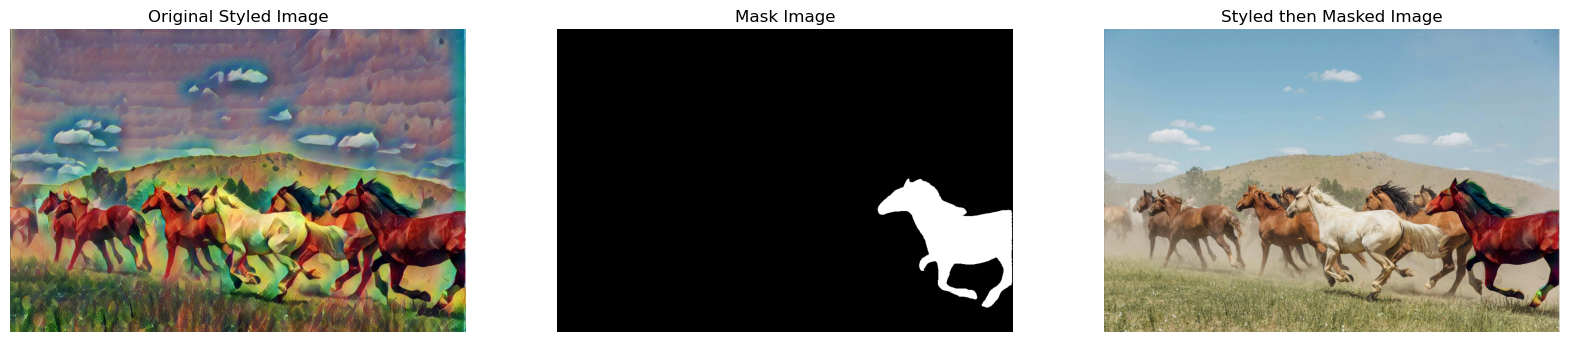

In [9]:
import os
import glob

### sort masks according to area descendingly
masks = sorted(masks, key=lambda x: x['area'], reverse=True)

segmented_masks = [
    mask['segmentation']
    for mask in masks
]

mask = (segmented_masks[4] * 255).astype(np.uint8) 

org_image = cv2.imread('horses.png')

linear_style_transfer_file = '/Users/ayberk.cansever/Documents/ECU/Thesis/LinearStyleTransfer/linearstyletransfer.py'
style_image_file = './styles/style-3.jpg'
styled_image_file = './output/styled-0.png'
org_styled_image_file = './output/org-style-4.jpg'


### style the original image
os.system('python ' + linear_style_transfer_file + ' ' + 'horses.png' + ' ' + style_image_file + ' ' + org_styled_image_file)

### resize styled image to original size    
org_styled_image = cv2.imread(org_styled_image_file)
target_height, target_width = org_image.shape[:2]
org_styled_image = cv2.resize(org_styled_image, (target_width, target_height), interpolation=cv2.INTER_LINEAR)


### regenerating styled-masked image
inverse_mask = cv2.bitwise_not(mask)
masked_original = cv2.bitwise_and(org_image, org_image, mask=inverse_mask)
styled_masked = cv2.bitwise_and(org_styled_image, org_styled_image, mask=mask)
final_styled_masked_image = cv2.add(masked_original, styled_masked)    

### plot the images
mask_image_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
org_styled_image_rgb = cv2.cvtColor(org_styled_image, cv2.COLOR_BGR2RGB)
final_styled_masked_image_rgb = cv2.cvtColor(final_styled_masked_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20, 20))

plt.subplot(1, 3, 1)
plt.imshow(org_styled_image_rgb)
plt.title('Original Styled Image')
plt.axis('off')

plt.subplot(1, 3, 2) 
plt.imshow(mask_image_rgb)
plt.title('Mask Image')
plt.axis('off')  

plt.subplot(1, 3, 3)
plt.imshow(final_styled_masked_image_rgb)
plt.title('Styled then Masked Image')
plt.axis('off')



# 2. Mask and Style

In [8]:
masked_image_file = './output/masked-4.jpg'
masked_styled_image_file = './output/masked-style-4.jpg'

### mask the original image
mask = (segmented_masks[4] * 255).astype(np.uint8) 
masked_image = cv2.bitwise_and(org_image, org_image, mask=mask)

### style the masked image
cv2.imwrite(masked_image_file, masked_image)
os.system('python ' + linear_style_transfer_file + ' ' + masked_image_file + ' ' + style_image_file + ' ' + masked_styled_image_file)

### resize styled image to original size    
masked_styled_image = cv2.imread(masked_styled_image_file)
target_height, target_width = org_image.shape[:2]
masked_styled_image = cv2.resize(masked_styled_image, (target_width, target_height), interpolation=cv2.INTER_LINEAR)


### regenerating masked-style image
inverse_mask = cv2.bitwise_not(mask)
masked_original = cv2.bitwise_and(org_image, org_image, mask=inverse_mask)
masked_styled = cv2.bitwise_and(masked_styled_image, masked_styled_image, mask=mask)
final_masked_styled_image = cv2.add(masked_original, masked_styled)    

### plot the images
masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
masked_styled_image_rgb = cv2.cvtColor(masked_styled_image, cv2.COLOR_BGR2RGB)
final_masked_styled_image_rgb = cv2.cvtColor(final_masked_styled_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20, 20))

plt.subplot(1, 3, 1) 
plt.imshow(masked_image_rgb)
plt.title('Masked Image')
plt.axis('off')  

plt.subplot(1, 3, 2)
plt.imshow(masked_styled_image_rgb)
plt.title('Masked Styled Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(final_masked_styled_image_rgb)
plt.title('Masked then Styled Image')
plt.axis('off')

NameError: name 'segmented_masks' is not defined

# 3. Plot the Styled-Masked and Masked-Styled Images

(-0.5, 1007.5, 668.5, -0.5)

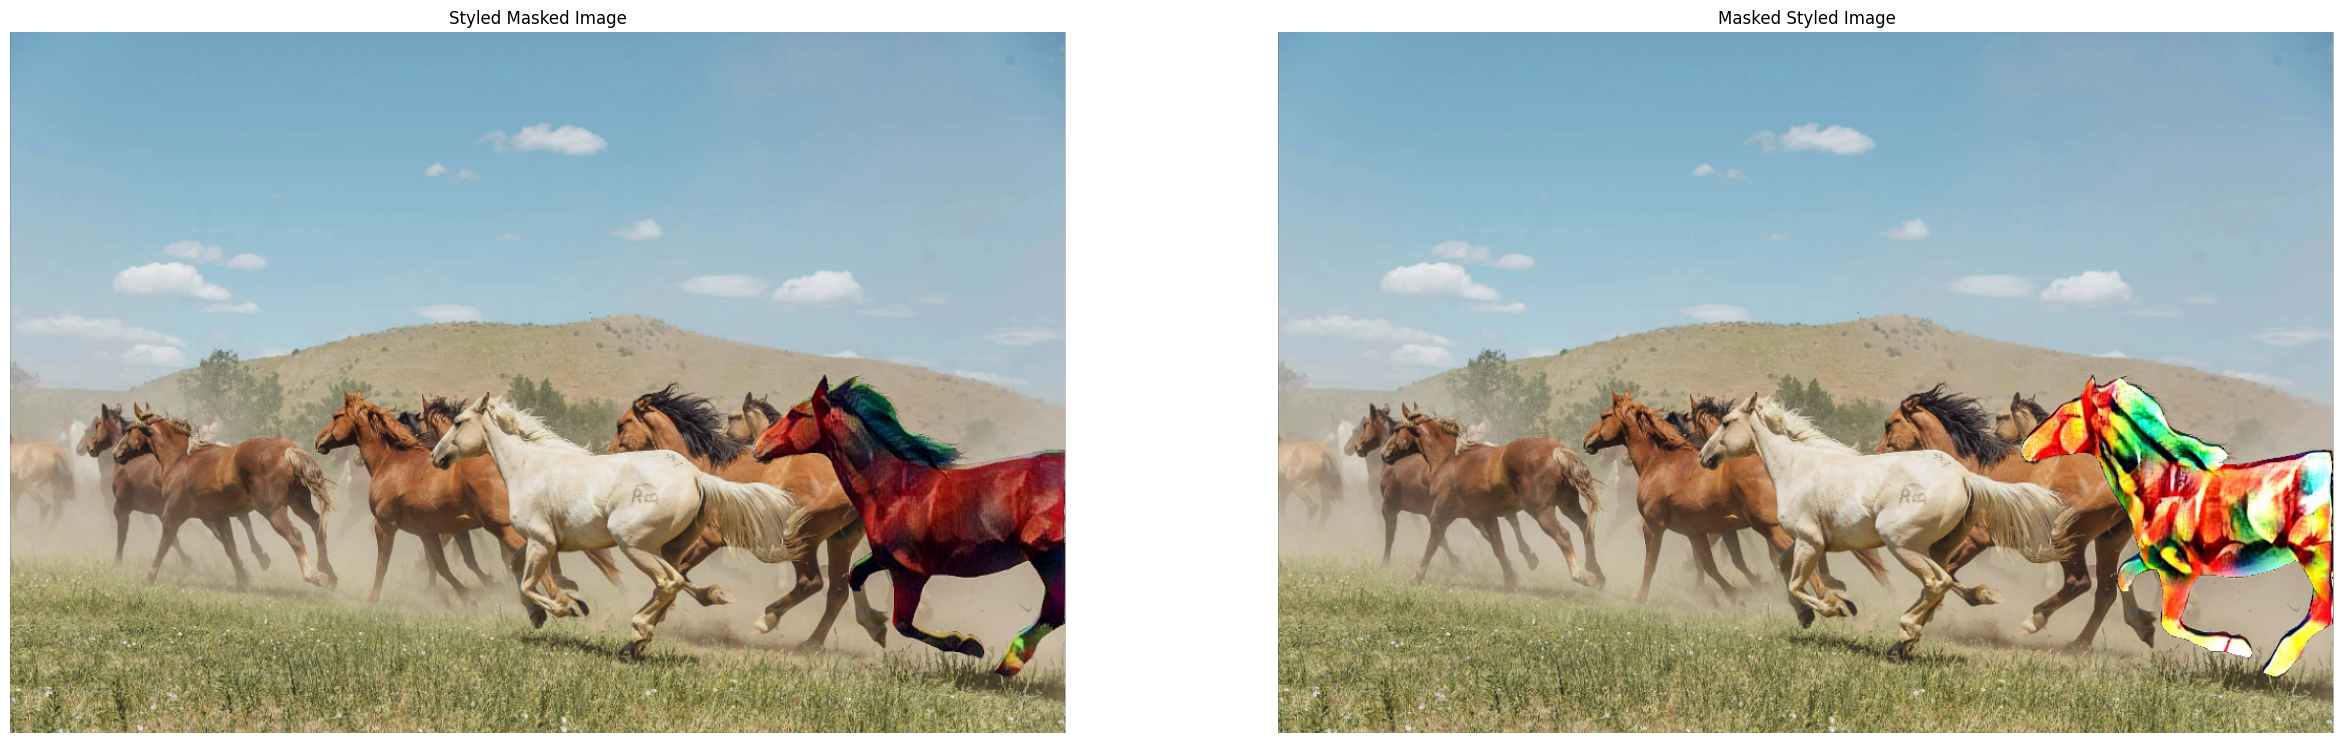

In [12]:
plt.figure(figsize=(30, 30))

plt.subplot(1, 2, 1) 
plt.imshow(final_styled_masked_image_rgb)
plt.title('Styled Masked Image')
plt.axis('off')  

plt.subplot(1, 2, 2)
plt.imshow(final_masked_styled_image_rgb)
plt.title('Masked Styled Image')
plt.axis('off')

In [ ]:
### TODO:

### masking - styling - regenerate the original image
### masking with bounding box - styling - regenerate the original image
### styling - masking - regenerate the original image

### create the pipeline

### partial convolution